In [1]:
import numpy as np
import seaborn as sns
import glob, gzip, pickle
from pylab import rcParams
import matplotlib.patches as patches
from pylab import Rectangle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
folder = '../nphc/nphc/datasets/simulated/exp/'
L = glob.glob(folder + '*')

In [238]:
len(L)

3

In [239]:
filename = L[2]
print(filename)

../nphc/nphc/datasets/simulated/exp/exp_d100_nonsym_1_log10T8_with_params_000.pkl.gz


In [240]:
f = gzip.open(filename)
data = pickle.load(f)
f.close()

In [ ]:
timestamps, Alpha = data[:2]

# Fit (=> compute the cumulants)

In [ ]:
import whma.cumulants as cu
half_width = 1000.
cumul = cu.Cumulants(timestamps, half_width=half_width)
cumul.compute_cumulants(half_width,method="parallel_by_day")

L is computed


# Solve (=> minimize the objective function via ADMM)

In [ ]:
from whma.solver import admm
from time import time
from whma.prox import prox_l1, prox_sq_frob, prox_l2, prox_zero, prox_nuclear
start = time.time()
G = admm(cumul, prox_l1, rho=1e0, maxiter=1000)
elapsed = time.time() - start

In [ ]:
print(elapsed)

In [235]:
from nphc.utils.metrics import rel_err
print(rel_err(Alpha,G))

0.179674105678


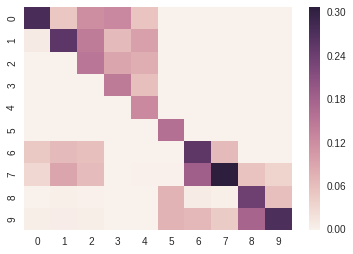

In [236]:
%matplotlib inline
import seaborn as sns
sns.heatmap(G)

In [149]:
# EXP 100
#
# L1 norm
# maxiter=1500 --> rel_err=0.0935
#
# squared L2 norm
# maxiter=100 --> rel_err=0.130
#
# nuclear norm
# maxiter=100 --> rel_err=0.131
#
#
# PLAW 10
# 
# L1 norm
# maxiter=1500 --> rel_err=0.147
#
# squared L2 norm
# maxiter=5000 --> rel_err=0.173
#
# nuclear norm
# maxiter=5000 --> rel_err=0.182
#
#
# PLAW 10
# 
# L1 norm
# maxiter=1500 --> rel_err=0.147
#
# squared L2 norm
# maxiter=5000 --> rel_err=0.173
#
# nuclear norm
# maxiter=100 --> rel_err=0.182

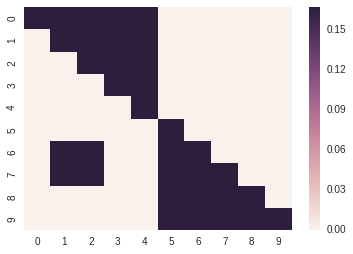

In [185]:
sns.heatmap(Alpha)

In [137]:
Alpha[0,0]

0.16666666666666666

# Nice heatmaps

In [135]:
from pylab import rcParams
from pylab import Rectangle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

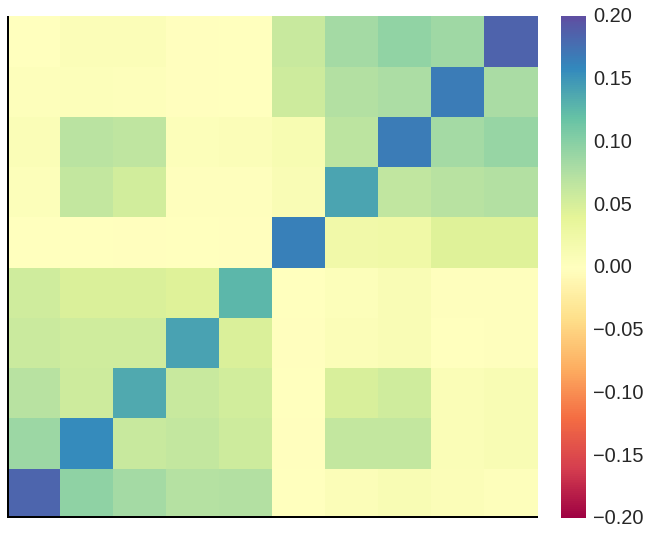

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))

heatmap = ax.pcolor(G,cmap='Spectral',vmin=-0.2,vmax=0.2)
#heatmap = ax.pcolor(Alpha,cmap='Spectral',vmin=-0.2,vmax=0.2)

ax.add_patch(
    patches.Rectangle(
        (0., 0.),   # (x,y)
        100,          # width
        100,          # height
        #facecolor="#00ffff",
        fill=False,
        linewidth=4
    )
)

ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_axis_off()

fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
#fig.colorbar(heatmap, cax=cbar_ax)
cb = fig.colorbar(heatmap, fraction=0.05, pad=0.04)
cb.ax.tick_params(labelsize=20)
fig.savefig("plaw10_sq_frob.png")